In [13]:
#Imports and everything else, better to not modify this part
import numpy as np
import sys
import pandas as pd
#
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
# from collections import namedtuple

try:
    # for Python2
    from Tkinter import *   ## notice capitalized T in Tkinter 
except ImportError:
    # for Python3
    from tkinter import *   ## notice lowercase 't' in tkinter here
    
    
    pd.set_option('display.max_rows', 100)


In [14]:
#Import gossip log and filter the messages received on grpc

fileHandle = open('/home/flav/gossip/gossip_data/data/lotus/vanillaGeneral/log_stdout.out', "r", encoding="latin1")
lines = fileHandle.readlines()

with open('/home/flav/gossip/gossip_data/filter/vanillaGeneral.out', 'w+') as f:
    for line in lines:
      if 'Validation' in line:
        print(line, file=f)
fileHandle.close()

In [15]:
# Create dataset for the gossip and correct the datetime
data = pd.read_csv('/home/flav/gossip/gossip_data/filter/vanillaGeneral.out', sep="|", header=None, error_bad_lines=False, warn_bad_lines=False)#, usecols=[0,2,5])
df = pd.DataFrame(data)

#Rename
df = df.rename(index=str, columns={0: "DateTime", 1: "Type", 2: "Hash"})
df["Type"] = df["Type"].str.replace(" ", "")
df["DateTime"] = df["DateTime"].str.replace(".", "")
df["DateTime"] = df["DateTime"].str.replace("-", "")
df["DateTime"] = df["DateTime"].str.replace(":", "")
df["DateTime"] = df["DateTime"].str.replace(" ", "")
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%Y%m%d_%H%M%S%f", errors="coerce")

df.tail(10)

# #Get only data when the cluster was stabilized
# # print(df.loc["DateTime" == "21397072576816640211201_195113"])
# df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce', format="%Y%m%d_%H%M%S")
# df = df.loc[df["DateTime"] > "2021-12-02 15:00:00"]
# df = df.loc[df["DateTime"] < "2021-12-03 00:25:00"]
# df = df[df["DateTime"].isin(pd.date_range("2021-12-01 19:25:00", "2021-12-01 20:28:00"))]


,DateTime,Type,Hash
552616,2022-06-09 19:18:12.158,ValidationDuplicated,BA6FBE7EE5FE11BE8506E957D9A1842202DF90A23431E...
552617,2022-06-09 19:18:12.158,ValidationDuplicated,BA6FBE7EE5FE11BE8506E957D9A1842202DF90A23431E...
552618,2022-06-09 19:18:12.159,ValidationDuplicated,BA6FBE7EE5FE11BE8506E957D9A1842202DF90A23431E...
552619,2022-06-09 19:18:12.159,ValidationDuplicated,BA6FBE7EE5FE11BE8506E957D9A1842202DF90A23431E...
552620,2022-06-09 19:18:12.160,ValidationDuplicated,BA6FBE7EE5FE11BE8506E957D9A1842202DF90A23431E...
552621,2022-06-09 19:18:12.161,ValidationDuplicated,BA6FBE7EE5FE11BE8506E957D9A1842202DF90A23431E...
552622,2022-06-09 19:18:12.161,ValidationDuplicated,BA6FBE7EE5FE11BE8506E957D9A1842202DF90A23431E...
552623,2022-06-09 19:18:12.162,ValidationDuplicated,BA6FBE7EE5FE11BE8506E957D9A1842202DF90A23431E...
552624,2022-06-09 19:18:12.162,ValidationDuplicated,BA6FBE7EE5FE11BE8506E957D9A1842202DF90A23431E...
552625,2022-06-09 19:18:12.163,ValidationDuplicated,BA6FBE7EE5FE11BE8506E957D9A1842202DF90A23431E...


In [16]:
unique = df.loc[df["Type"] == "ValidationUnique"]
dups = df.loc[df["Type"] == "ValidationDuplicated"]


# unique.head(10)
dupsList = dups["Hash"].unique()
trulyUnique = unique[~unique["Hash"].isin(dupsList)]

trulyUnique.count()
# trulyUnique.style


DateTime    10
Type        10
Hash        10
dtype: int64

In [17]:
#Count duplications
dupsGrouped = df.drop(columns=["DateTime", "Type"])
dupsCount = dupsGrouped.groupby(dupsGrouped.columns.tolist()).size().reset_index().rename(columns={0:'dups'}).sort_values(by=["dups"], ascending=False)

# dupsCount.head(10)
dupsSave=dupsCount.loc[dupsCount["dups"] < 25]
dupsSave.tail(10)
dupsSave.to_csv('/home/flav/gossip/gossip_data/dupsvanillaGeneral.csv')

In [18]:
#Consolidate
dist = dupsCount.drop(columns=["Hash"])

dist = dist.groupby(dist.columns.tolist()).size().reset_index().rename(columns={0:'distribution'}).sort_values(by=["distribution"], ascending=False)

dist.head(50)

,dups,distribution
22,23,6677
21,22,4509
20,21,3096
19,20,2236
18,19,1676
17,18,1418
16,17,1353
15,16,1297
14,15,1243
13,14,1197


In [19]:
#Percentage of duplicates
totalMessages = dist["distribution"].sum()
perc = dist

perc["percentage"] = (perc["distribution"]*100)/totalMessages
perc = perc.sort_values(by="distribution", ascending=False)

perc.style

,dups,distribution,percentage
22,23,6677,22.0713
21,22,4509,14.9048
20,21,3096,10.234
19,20,2236,7.39125
18,19,1676,5.54013
17,18,1418,4.68729
16,17,1353,4.47243
15,16,1297,4.28732
14,15,1243,4.10882
13,14,1197,3.95676


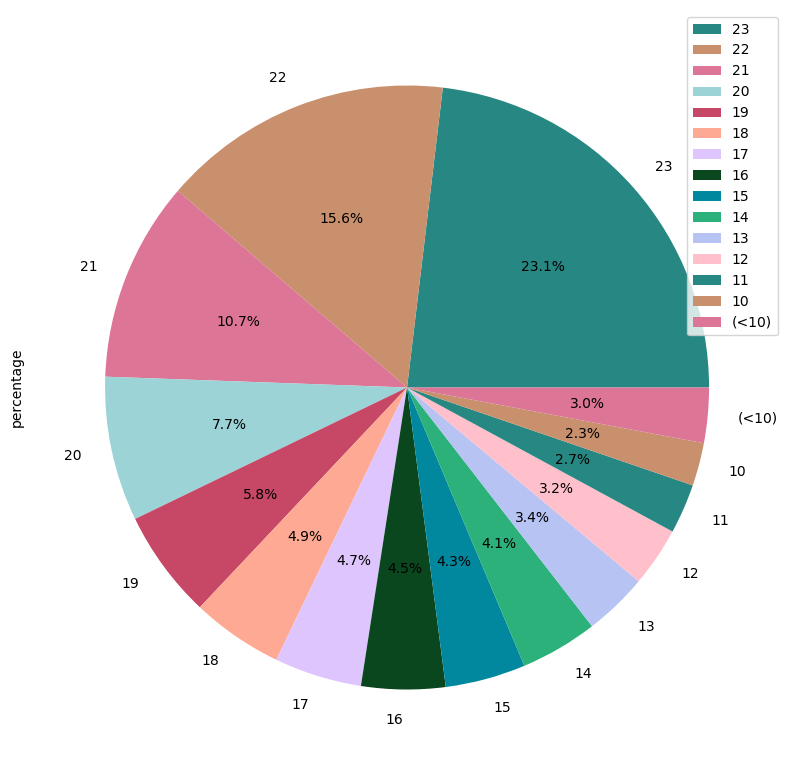

In [20]:
#Plot percentage

#If the percenatge is under 1%, put on the category "other"
percPlot = perc.loc[perc["percentage"] > 2].drop(columns=["distribution"])

# % under 1%
percOther = perc["percentage"].loc[perc["percentage"] <= 1].sum()
# generate row to append
percOtherRow = pd.DataFrame([["(<10)", percOther]], columns=["dups", "percentage"])

percPlot=percPlot.append(percOtherRow, ignore_index=True)
# percPlot = percPlot.reindex(percPlot["dups"])

#set colors, cause they are repeting when on automatic
colors = ['#278782', '#c9906d', '#DD7596', '#9cd3d6', '#c74767', '#fea993', '#dfc5fe', '#0a461e', '#01889f', '#2bb179', '#B7C3F3', 'pink'] 

percPlot.style
percPlotPie = percPlot.plot(kind="pie", y="percentage", figsize=(10,10), autopct="%1.1f%%", labels=percPlot["dups"], colors=colors)

fig = percPlotPie.get_figure()
# fig.savefig("percentageDupsvanillaGeneral.png")

[Text(0, 0.5, 'Frequency'), Text(0.5, 1.0, 'Frequency Histogram')]

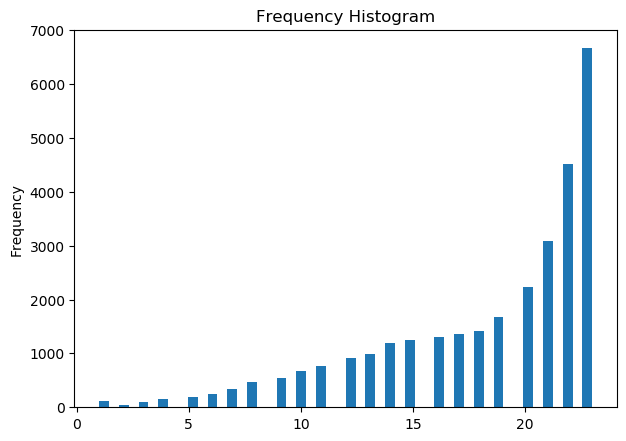

In [21]:
#Histogram
hist = dupsCount['dups']
# dups.head(5)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.hist(hist, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')